In [1]:
import confmain
import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf

import pywt
import wfdb
from wfdb import processing

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from util_module import util_func
from util_module.ecg_signal import ECGSignal

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, '../data/ludb')

**ST-elevation on records [7, 21, 24, 33, 55, 64, 69, 86]**

In [3]:
def remove_zero_padding(signal, segment, thresh=50):
    if len(signal) != len(segment):
        print('Signal and segment length mismatch!')
        return

    counter = 0
    ptr_start_zero_pad = 0

    for i in reversed(range(len(signal))):
        if (signal[i] != 0) and (segment[i] != 7):
            counter += 1
            if (signal[i+1] == 0) and (segment[i+1] == 7):
                ptr_start_zero_pad = i + 1
        
        if (signal[i] == 0) and (segment[i] == 7):
            counter = 0
        
        if counter == thresh:
            break
    
    signal = signal[:ptr_start_zero_pad]
    segment = segment[:ptr_start_zero_pad]

    return signal, segment

In [5]:
INPUT_LENGTH = 816

FS = 500
T1 = 125
T2 = 245

MIN_BPM = 20
MAX_BPM = 230

SEARCH_RADIUS = int(FS * 60 / MAX_BPM)

WAVELET_FUNCTION = 'bior3.3'
DECOMPOSITION_LEVEL = 7

STEMI_RECORD = [7, 21, 24, 33, 55, 64, 69, 86]
# LEADS = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
# STEMI_RECORD = [7]
LEADS = ['v2']

In [6]:
# DEPRECATED

# def get_amp_diff(lead, sex, age):
#     amp_diff = 0.1
#     if lead == 'v2' or lead == 'v3':
#         if sex == 'M':
#             if age >= 40:
#                 amp_diff = 0.2
#             elif age < 40:
#                 amp_diff = 0.25
        
#         elif sex == 'F':
#             amp_diff = 0.15
    
#     else:
#         amp_diff = 0.1
    
#     return amp_diff

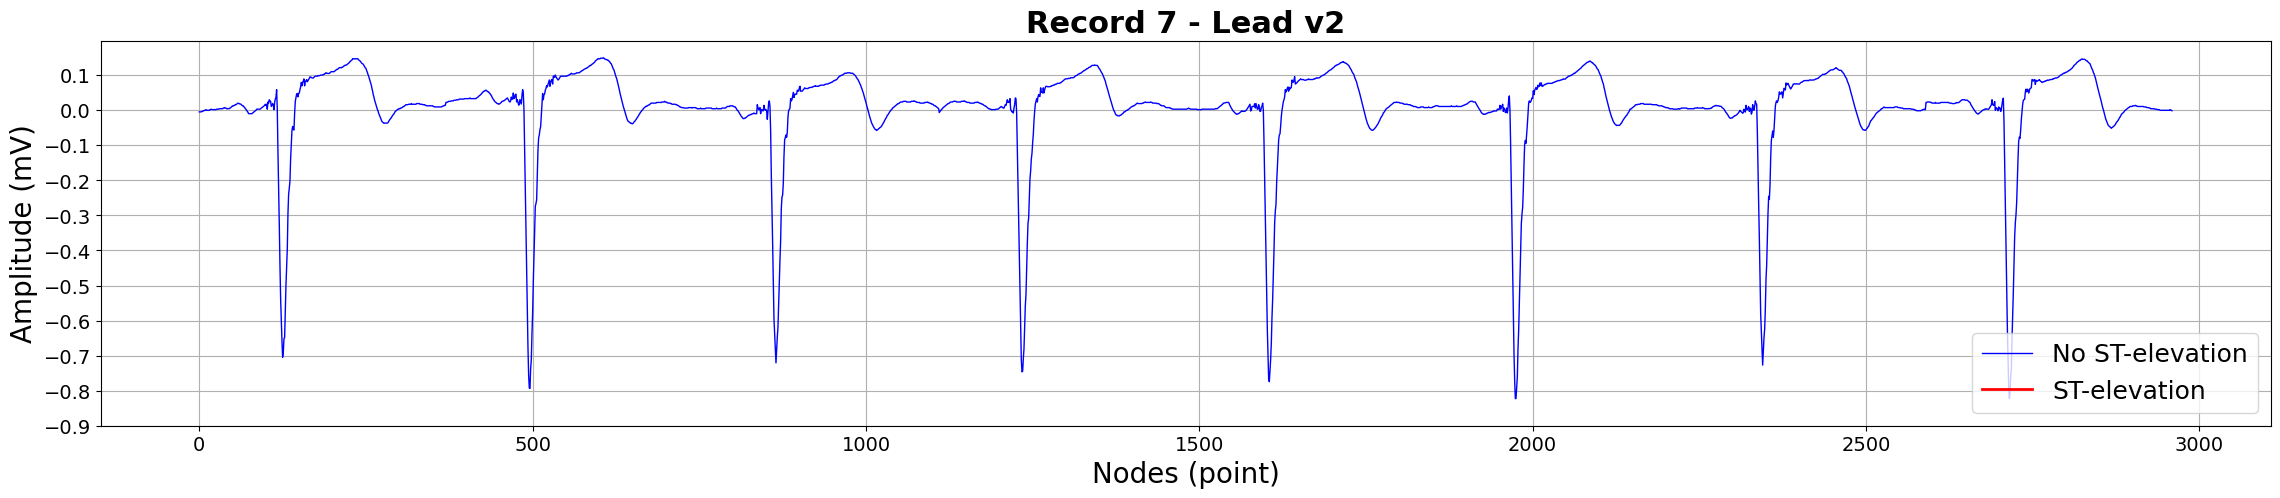

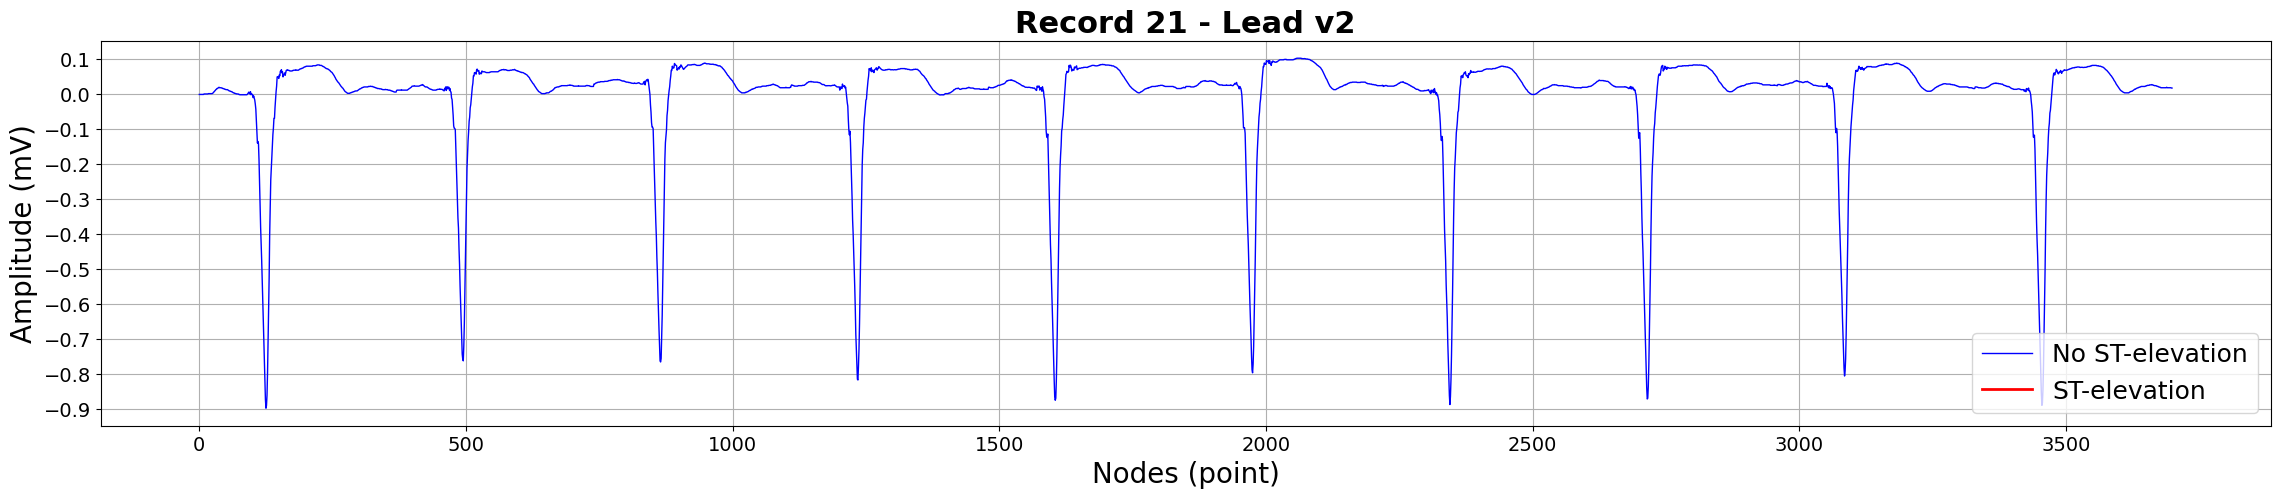

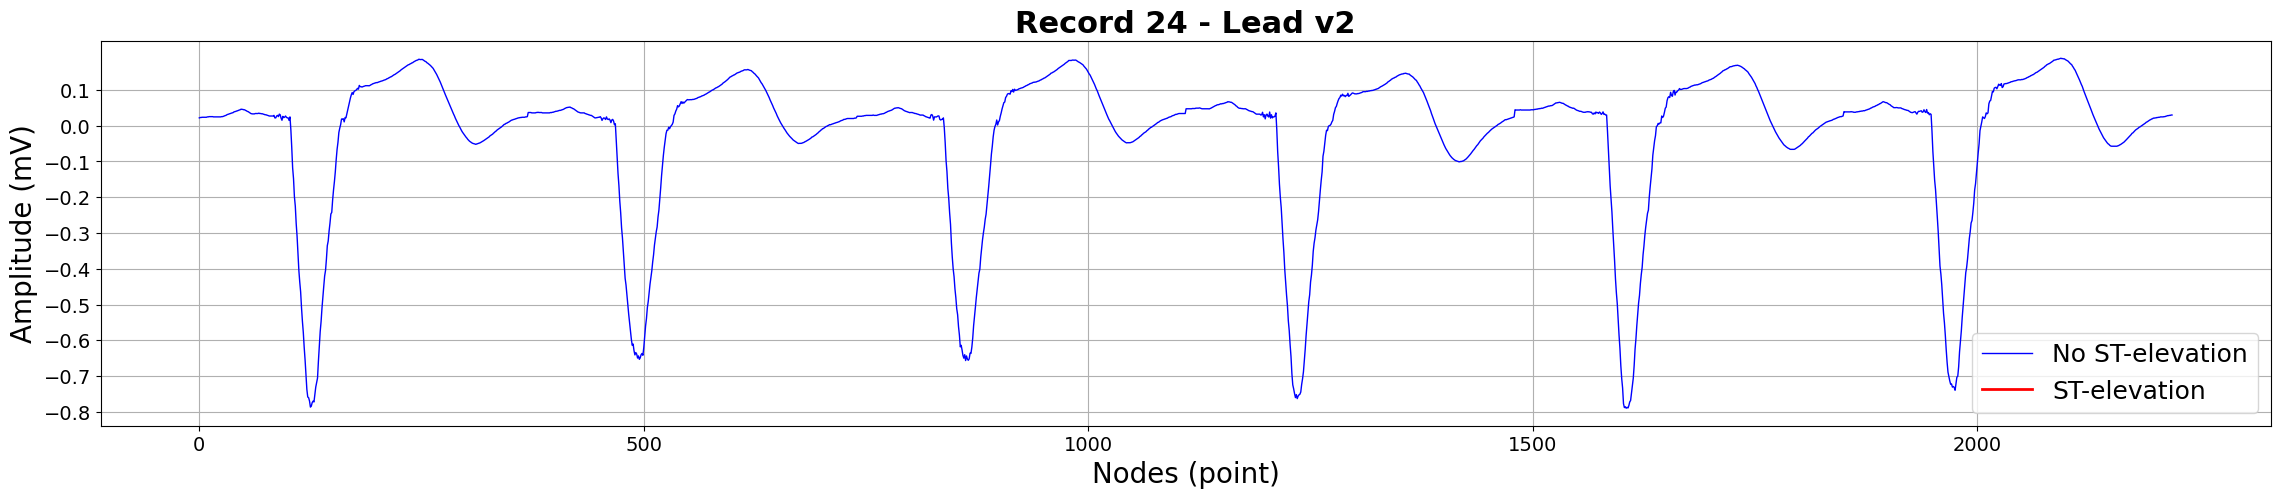

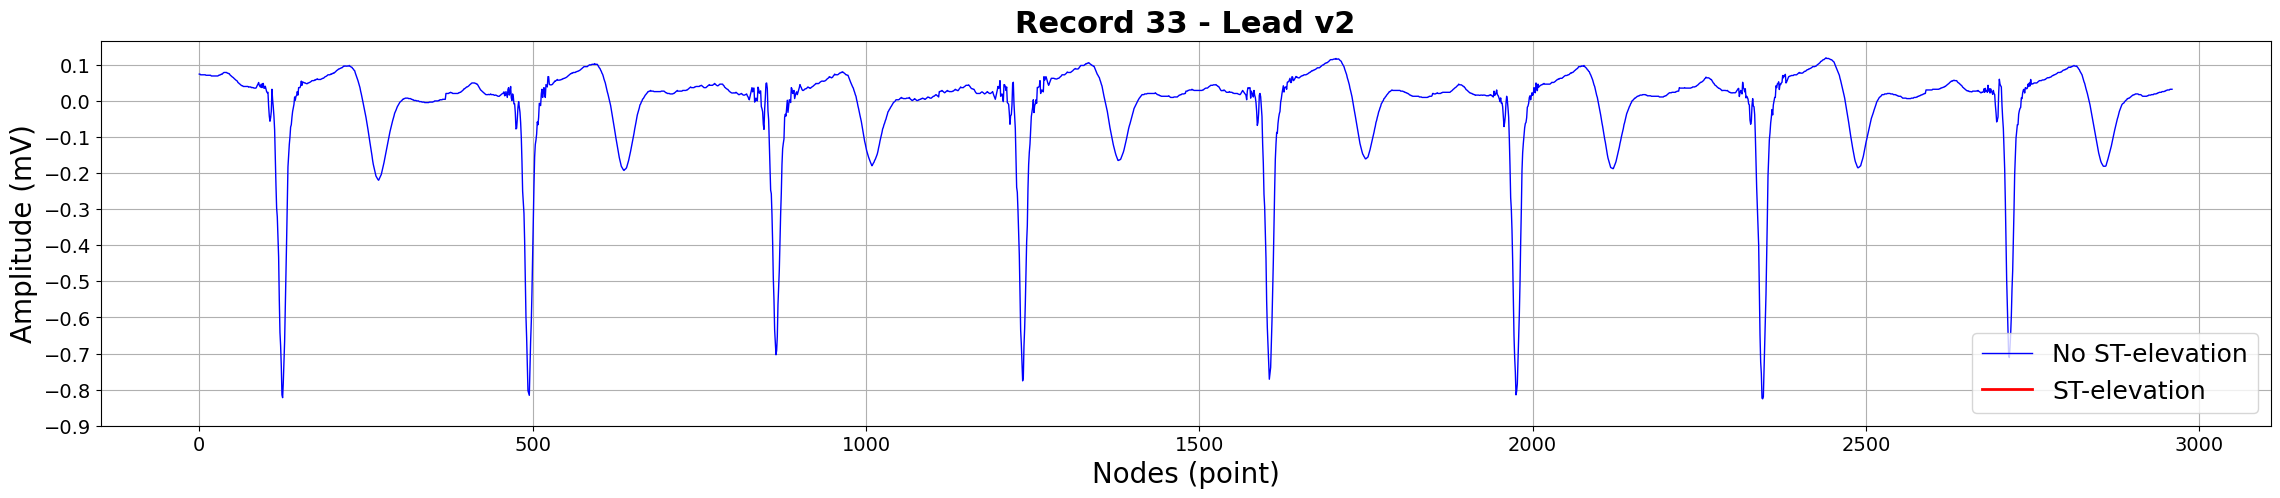

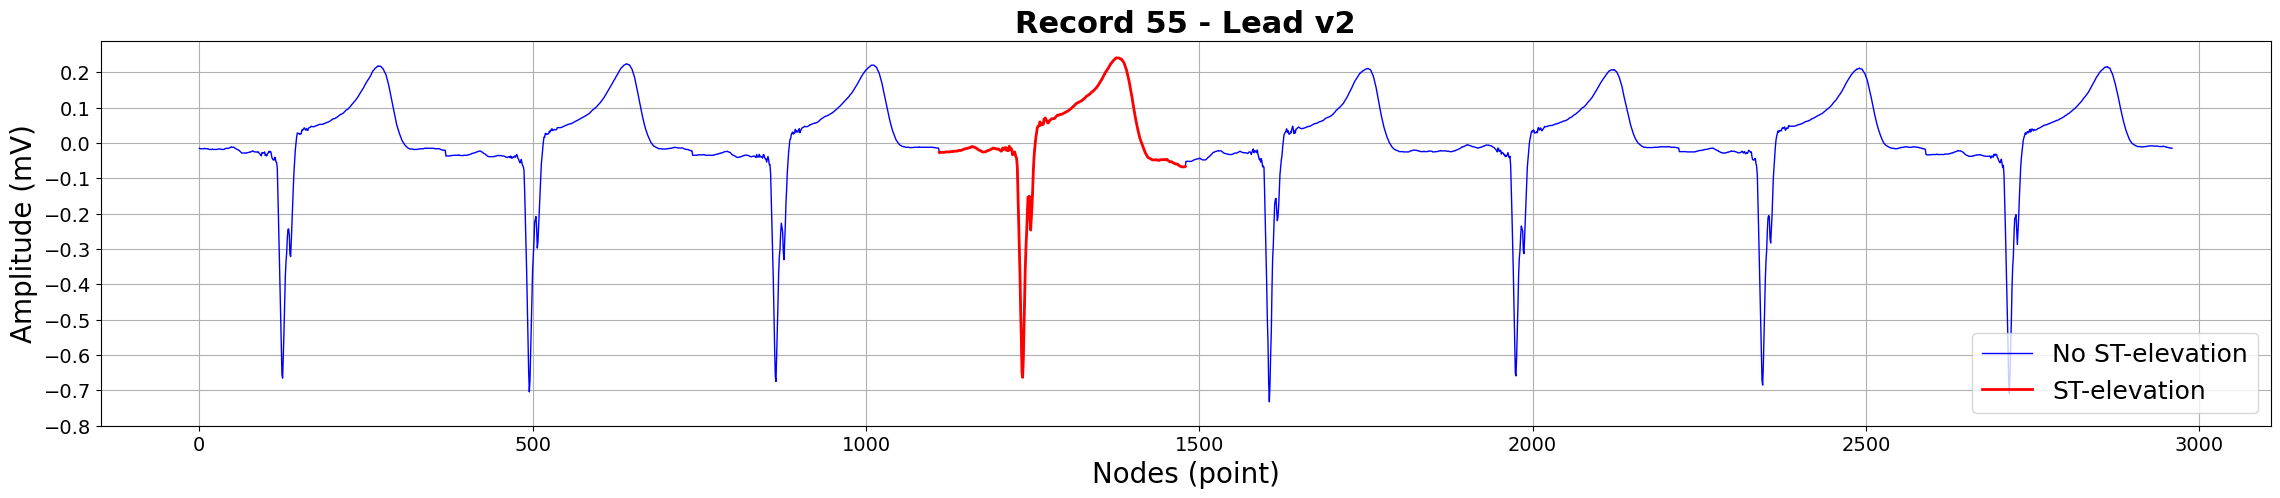

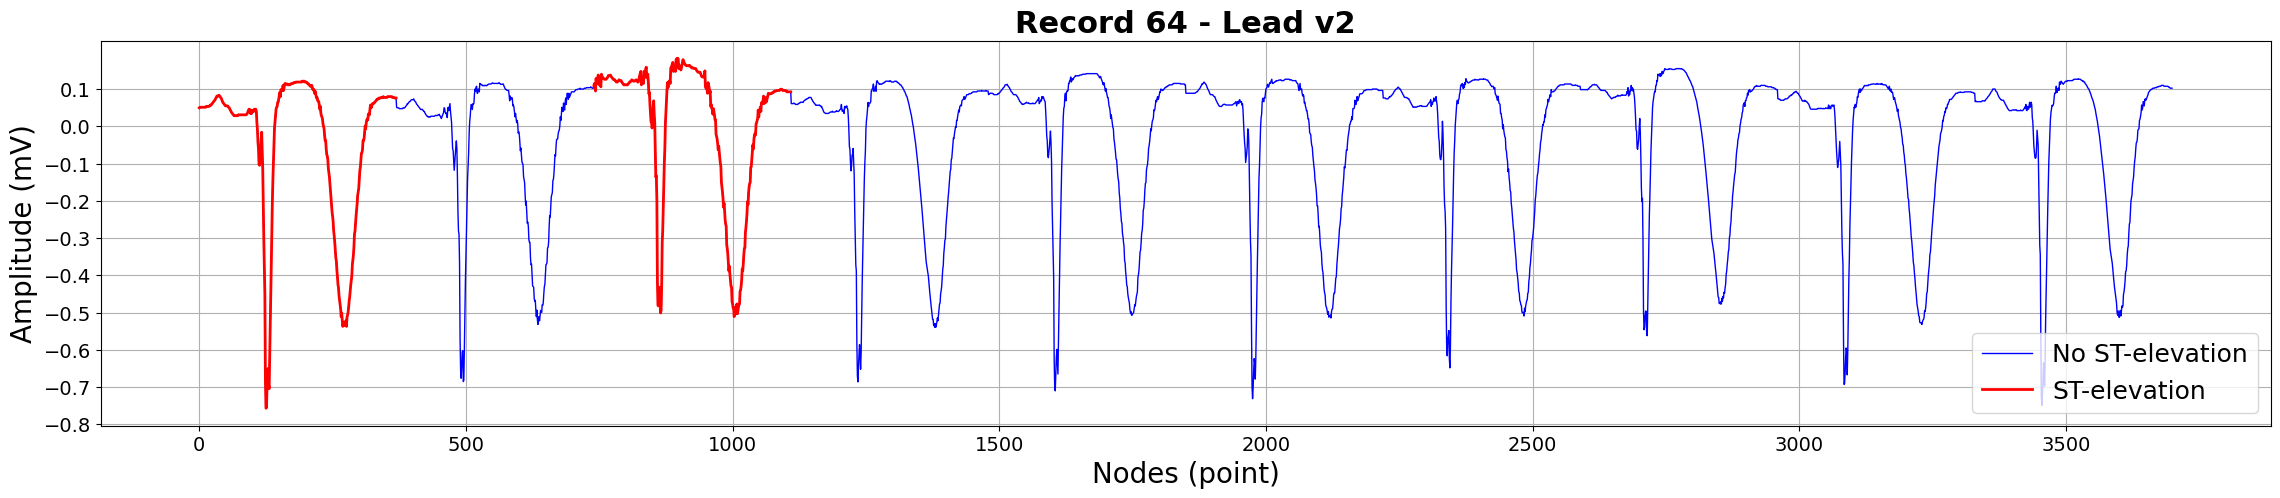

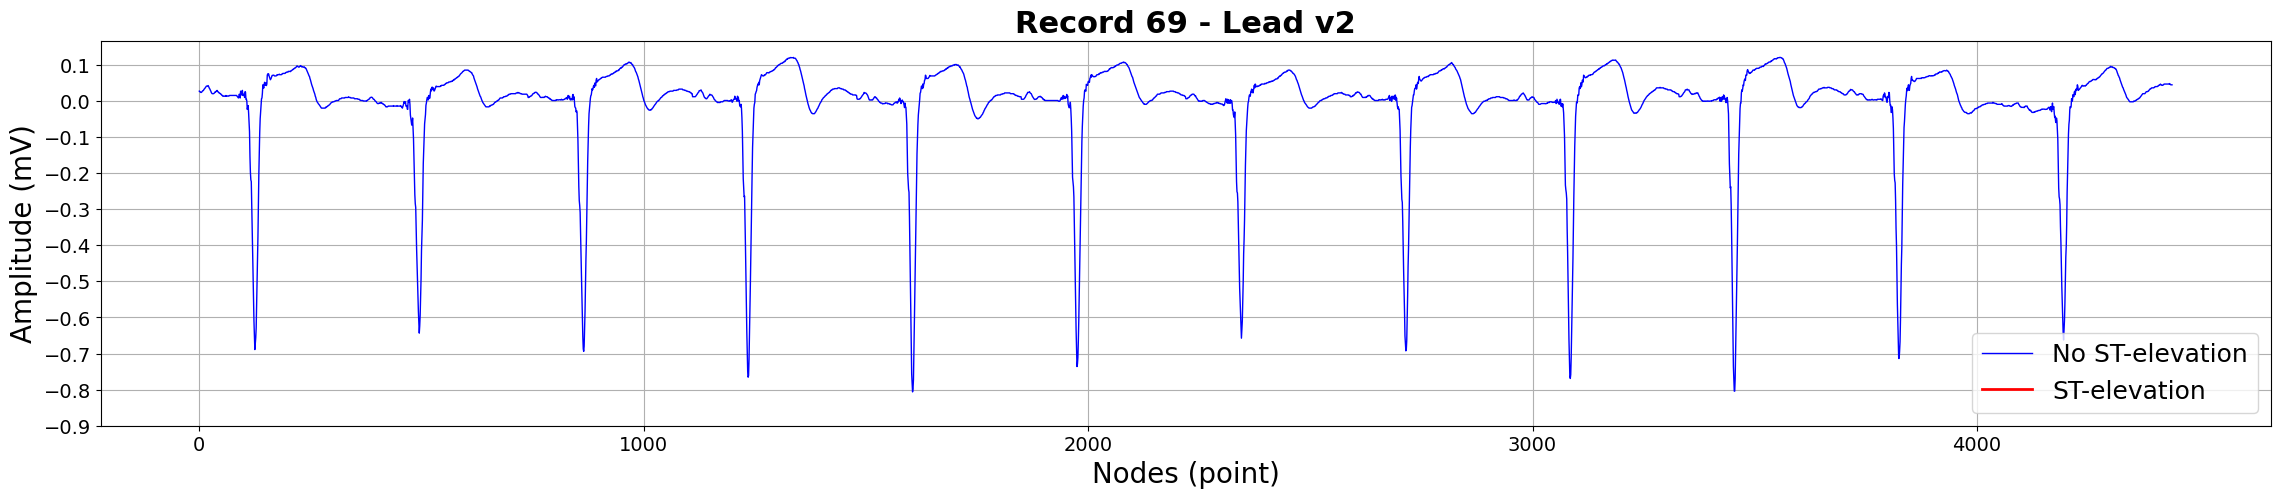

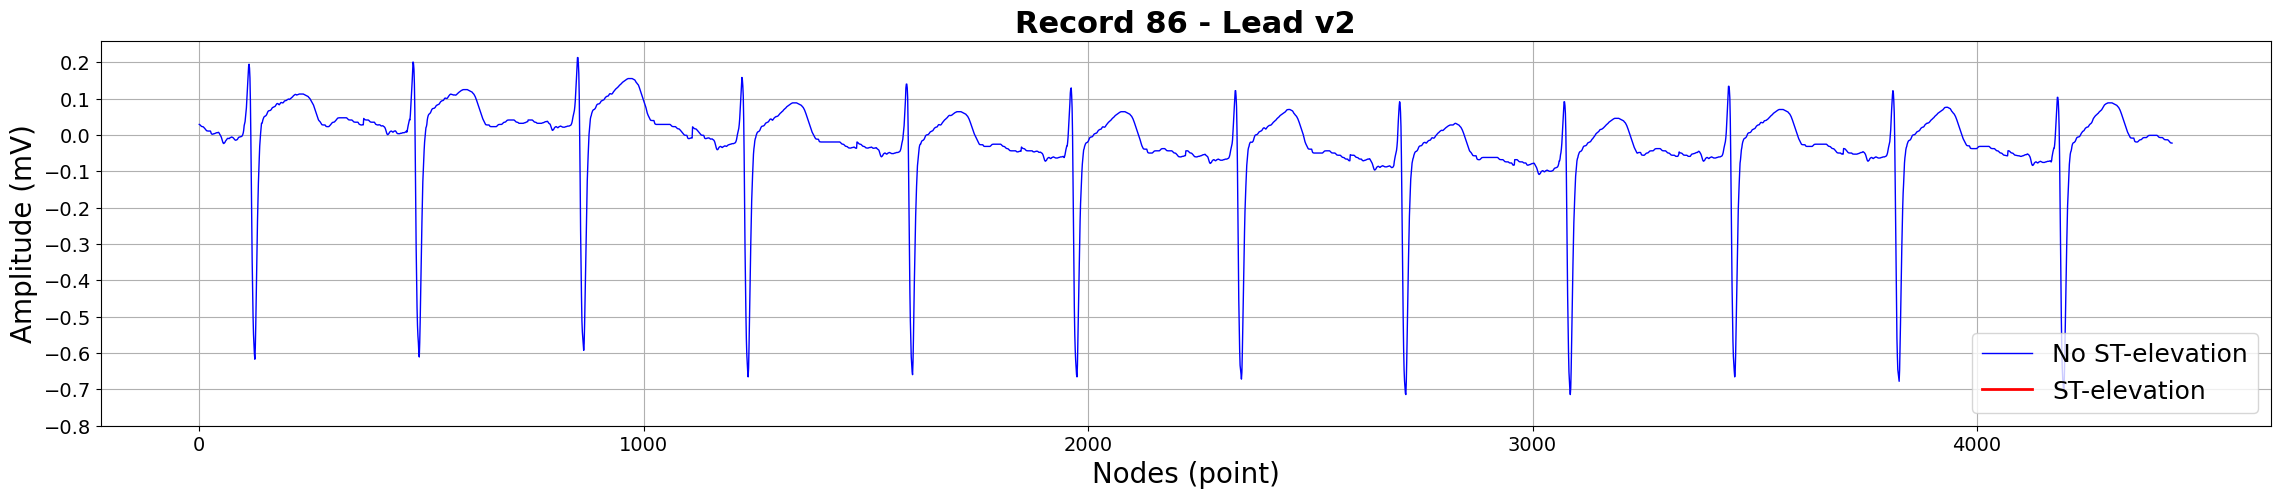

In [8]:
for lead in LEADS:
    data = ECGSignal.get_signal(leads=[lead])

    model = tf.keras.models.load_model(f'../model/{lead}-CustomModel.h5')
    
    stemi_data = zip(
        [data['record_number'][i-1] for i in STEMI_RECORD],
        [data['signal'][i-1] for i in STEMI_RECORD],
    )

    for record_num, signal in stemi_data:
        signal = util_func.denoise_dwt(signal, wavelet=WAVELET_FUNCTION, level=DECOMPOSITION_LEVEL)
        raw_signal = signal
        signal = processing.normalize_bound(signal)

        index_qrs = processing.gqrs_detect(signal, fs=FS)

        if len(index_qrs) == 0:
            print("Can't detect QRS")
            continue

        corrected_peak_inds = processing.peaks.correct_peaks(
            signal,
            peak_inds=index_qrs,
            search_radius=SEARCH_RADIUS,
            smooth_window_size=150,
        )

        if len(corrected_peak_inds) % 2 != 0:
            corrected_peak_inds = np.delete(corrected_peak_inds, -1)

        offset = 0
        beats = []
        raw_beats = []
        delineations = []
        interpretations = [0]*len(corrected_peak_inds)
        st_elev_start_end = []
        for j, peak in enumerate(corrected_peak_inds):
            if (peak - T1) < 0 or (peak + T2) > len(signal):
                continue
            
            raw_beat = raw_signal[peak - T1 : peak + T2]
            beat = signal[peak - T1 : peak + T2]

            beat = np.pad(beat, (0, INPUT_LENGTH - len(beat)))
            beat = beat.reshape((1, -1, 1))

            y_pred = model.predict(beat, verbose=0)
            y_pred = y_pred.round().reshape((INPUT_LENGTH, 8))
            y_pred = y_pred.argmax(axis=1)

            segment_start_end = util_func.get_segment_start_end(y_pred)

            beat = beat.flatten()

            beat, y_pred = remove_zero_padding(beat, y_pred)
            
            beats.extend(beat)
            raw_beats.extend(raw_beat)
            delineations.extend(y_pred)


            try:
                tp_segment = segment_start_end[6][0]
                st_segment = segment_start_end[4][0]
            except:
                print(f'Record number {record_num} failed.')
                ECGSignal.plot_signal_segments(signal, y_pred)

            baseline_amp = np.mean(beat[tp_segment[0]:tp_segment[1]+1])
            j_point_amp = beat[st_segment[1]]

            # fig, ax = plt.subplots(figsize=(28, 5))

            # ECGSignal.plot_signal_segments(beat, y_pred, ax=ax)

            # ax.plot(st_segment[0], j_point_amp, 'bo')
            # ax.axhline(y=baseline_amp, color='r', linestyle='-')

            if j_point_amp - baseline_amp >= 0.1: # Universal ST elevation rules
                st_elev_start_end.append((offset, offset + len(beat)))
            
            offset += len(beat)                
            
        fig, ax = plt.subplots(figsize=(28, 5))

        ax.plot(raw_beats, color='blue', linewidth=1)
        for st_elev_start, st_elev_end in st_elev_start_end:
            ax.plot(range(st_elev_start, st_elev_end), raw_beats[st_elev_start:st_elev_end], color='red', linewidth=2)

        ax.set_xlabel('Nodes (point)', fontsize=20)
        ax.set_ylabel('Amplitude (mV)', fontsize=20)

        ax.set_yticks(np.arange(
            math.floor(np.min(raw_beats) * 10) / 10,
            (math.ceil(np.max(raw_beats) * 10) / 10),
            0.1)
        )
        ax.grid()
        legend_patches = [
            Line2D([0], [0], label='No ST-elevation', color='blue', linewidth=1),
            Line2D([0], [0], label='ST-elevation', color='red', linewidth=2)
        ]
        ax.legend(handles=legend_patches, loc='lower right', fontsize=18)

        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.set_title(f'Record {record_num} - Lead {util_func.get_lead_display_name(lead)}', weight='bold', fontsize=22)

        util_func.make_dir(f'../result/st-elevation-detection/{record_num}')
        fig.savefig(f'../result/st-elevation-detection/{record_num}/{record_num}-{lead}', bbox_inches='tight')